In [2]:
%pip install networkx

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.neighbors import kneighbors_graph
import numpy as np
import networkx as nx

# Generate synthetic data
from sklearn.datasets import make_blobs
data, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.7, random_state=42)

# Create a k-NN graph
k = 10  # Number of neighbors
knn_graph = kneighbors_graph(data, n_neighbors=k, mode='distance', include_self=False)

# Convert to NetworkX graph for visualization and manipulation
G = nx.from_scipy_sparse_array(knn_graph)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:310: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


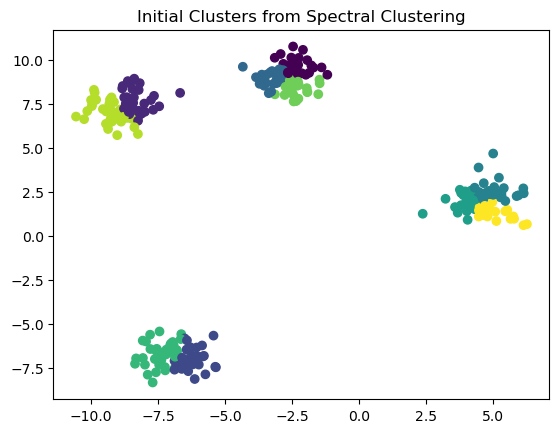

In [3]:
from sklearn.cluster import SpectralClustering

# Apply Spectral Clustering to partition the graph
num_initial_clusters = 10  # Initial partitions
spectral_clustering = SpectralClustering(n_clusters=num_initial_clusters, affinity='precomputed', random_state=42)
labels = spectral_clustering.fit_predict(knn_graph.toarray())

# Visualize initial clusters
import matplotlib.pyplot as plt
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
plt.title("Initial Clusters from Spectral Clustering")
plt.show()


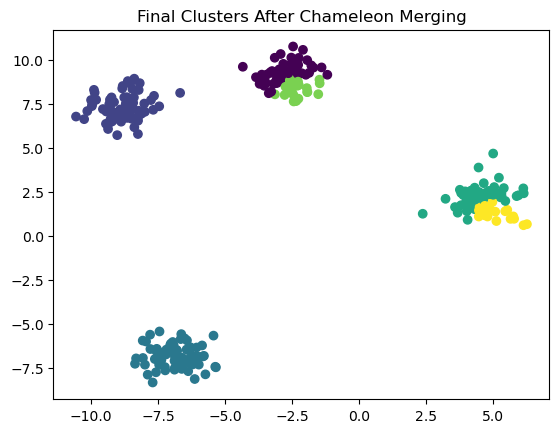

In [6]:
# Calculate inter-cluster edge weights
def calculate_edge_weights(graph, clusters):
    cluster_edges = {}
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            edge_weights = 0
            for u in clusters[i]:
                for v in clusters[j]:
                    if graph.has_edge(u, v):
                        edge_weights += graph[u][v].get("weight", 1)
            cluster_edges[(i, j)] = edge_weights
    return cluster_edges

# Extract nodes of each cluster
cluster_nodes = [np.where(labels == i)[0] for i in range(num_initial_clusters)]

# Compute edge weights for merging
edge_weights = calculate_edge_weights(G, cluster_nodes)

# Merge clusters based on weights (simple example using max edge weight)
merge_threshold = np.mean(list(edge_weights.values()))  # Example: use mean weight as a threshold
merged_clusters = []
visited = set()

for (i, j), weight in edge_weights.items():
    if weight > merge_threshold and i not in visited and j not in visited:
        merged_clusters.append(np.concatenate((cluster_nodes[i], cluster_nodes[j])))
        visited.add(i)
        visited.add(j)

# Add unmerged clusters
merged_clusters.extend([cluster_nodes[i] for i in range(num_initial_clusters) if i not in visited])

# Visualize merged clusters
final_labels = np.zeros(len(data), dtype=int)
for idx, cluster in enumerate(merged_clusters):
    final_labels[cluster] = idx

plt.scatter(data[:, 0], data[:, 1], c=final_labels, cmap='viridis')
plt.title("Final Clusters After Chameleon Merging")
plt.show()
